## [Time Series Forecasting with Moirai](https://medium.com/@kylejones_47003/time-series-forecasting-with-moirai-5d063a40e9ed)

`Moirai` is a time series language model from [Salesforce](https://salesforce.com). Named for the three fates who control destiny, it is easy-to-use and fast (wall time was 1.7 seconds for this to make the predictions below). Moirai is a Masked Encoder-based Universal Time Series Forecasting Transformer trained on the Large-scale Open Time Series Archive (LOTSA) (27 billion observations across nine domains).

In [1]:
!pip install -q numpy pandas matplotlib
!pip install -q torch uni2ts "gluonts" "gluonts[torch]" orjson

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

k_df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "edwardmattern/ercot-electricity-model", "ERCOT_dataset.csv")

# Download latest version
# path = kagglehub.dataset_download("edwardmattern/ercot-electricity-model", path="../data")
# print("Path to dataset files:", path)

k_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167k/167k [00:01<00:00, 165kB/s]


,Date,ERCOT,NG1:COM,NGEU:COM,BTCUSD:CUR,TSLA:US,CL1:COM,UXA:COM,RIVN:US,CPI,...,USAENEINF,FDTR,UNITEDSTACRUOILPRO,UNITEDSTAOILEXP,WIND:IND,SOLAR:IND,NUCLEAR:IND,TMAX,TMIN,TAVG
0,4/8/24,43277.56926,1.86,29.60,71703.00,172.98,86.43,88.75,10.44,312.332,...,2.121,5.5,12533,10355.144,15.44,43.74,30.92,79,55,67
1,4/5/24,43223.97195,1.79,28.20,67638.37,164.90,86.91,90.74,10.10,312.332,...,2.121,5.5,12533,10355.144,15.29,43.13,30.54,84,46,65
2,4/4/24,43286.15326,1.77,27.78,67952.00,171.11,86.59,90.90,10.13,312.332,...,2.121,5.5,12533,10355.144,15.28,43.72,30.21,72,46,59
3,4/3/24,43259.42649,1.84,27.10,65728.00,168.38,85.43,90.60,10.54,312.332,...,2.121,5.5,12533,10355.144,15.38,43.88,31.38,70,53,62
4,4/2/24,43167.79365,1.86,27.78,65659.00,166.63,85.15,90.94,10.51,312.332,...,2.121,5.5,12533,10355.144,15.23,43.39,30.39,80,63,72


In [4]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

SIZE = "small"  # Model size
PDT = 64  # Prediction length
CTX = 200  # Context length
PSZ = "auto"  # Patch size
BSZ = 32  # Batch size
TEST = 64  # Test set length

In [ ]:
# Load data
## Ercot_Native_Load_2025 (1).csv
# ercot_url = 'https://raw.githubusercontent.com/jgscott/ECO395M/refs/heads/master/data/ercot/load_data.csv'
# df = pd.read_csv(f"{ercot_url}")
# df.head(10)

In [5]:
k_df["timestamp"] = pd.to_datetime(k_df["Date"])
k_df.set_index("timestamp", inplace=True)

In [6]:
k_df["ERCOT"] = pd.to_numeric(k_df["ERCOT"], errors="coerce")
k_df = k_df.asfreq("h")  # Hourly frequency

In [7]:
k_df.head(10)

,Date,ERCOT,NG1:COM,NGEU:COM,BTCUSD:CUR,TSLA:US,CL1:COM,UXA:COM,RIVN:US,CPI,...,USAENEINF,FDTR,UNITEDSTACRUOILPRO,UNITEDSTAOILEXP,WIND:IND,SOLAR:IND,NUCLEAR:IND,TMAX,TMIN,TAVG
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-30 00:00:00,4/30/19,42608.65561,2.58,15.29,5269.0,22.37,65.21,25.2,78.0,255.548,...,1.677,2.5,12135.0,5542.67,13.36,25.09,12.12,81.0,68.0,75.0
2019-04-30 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(k_df[["ERCOT"]]))

In [9]:
train, test_template = split(ds, offset=-TEST)
test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=TEST // PDT,
    distance=PDT,
)

In [10]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

In [11]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

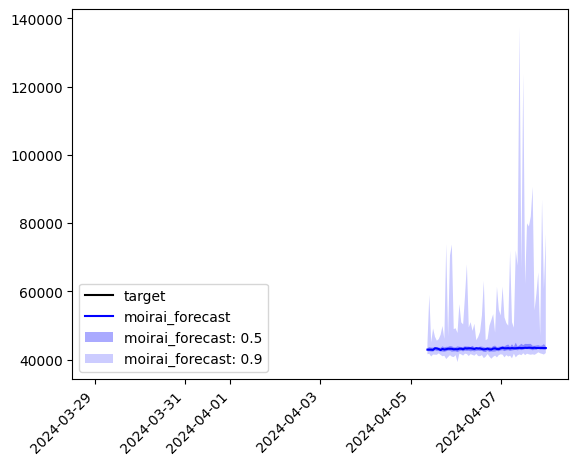

In [12]:
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)
plot_single(
    inp,
    label,
    forecast,
    context_length=CTX,
    name="moirai_forecast",
    show_label=True,
)
plt.show()